# Make a simple FeedForward network for the bus data

## Initialization

In [37]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
from BaseNetwork import BaseNetwork
import torch
from torch.nn import Linear, Sequential, ReLU, L1Loss
from torch.optim import Adam, lr_scheduler
import numpy as np

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data using the MoviaBusDataset

In [38]:
previous_timesteps = 6
prediction_steps = 6
batch_size = 25
num_epochs = 100

train = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=previous_timesteps, 
                        max_future_time_steps=prediction_steps, 
                        timeofday = True)
test = MoviaBusDataset('../data/test', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps, 
                       timeofday = True)

train.normalize()
test.normalize(train.mean, train.std)

../misc\MoviaBusDataset.py:117: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat((dataframe.drop('TimeOfDay', axis=1) for dataframe in self.dataframes))


## The Model

In [40]:
class FNN(BaseNetwork):
    def __init__(self, num_hidden):
        super().__init__()
        

        self.FNN = Sequential(
            Linear(previous_timesteps+1, num_hidden),
            ReLU(),
            Linear(num_hidden, num_hidden),
            ReLU(),
            Linear(num_hidden, 1),
        )

    def forward(self,x):
        """
        x : [batch_size, prev_timesteps, num_roads]
        
        """
        #Transpose input, such that the previous time steps are the last dimension
        x = x.transpose(2,1)

        predictions = []
        for _ in range(self.max_timestep):
            #Run the input through the network
            prediction = self.FNN(x).squeeze()

            #Append the prediction to the list of predictions. 
            #If the data includes timeofday, this shouldn't be included
            predictions.append(prediction[:,:self.num_roads])

            #remove oldest timestep
            x = x[:,:,1:]
            #unsqueeze output so its size is [batch_size, num_roads, timesteps]
            prediction = prediction.unsqueeze(2)

            #append the new prediction to the input
            x = torch.cat((x,prediction),dim=2)


        return torch.stack(predictions,1)

net = FNN(num_hidden=100)

optimizer_fun = lambda param : Adam(param, lr=1e-2, weight_decay=1e-4)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
criterion = L1Loss()

## Training the network

In [41]:
net.train_network(train, test,batch_size=batch_size, 
                  num_epochs=1,
                  optimizer_fun=optimizer_fun,
                  scheduler_fun=scheduler_fun,
                  criterion=criterion)

epoch =  0  train loss = 0.733   test loss = 0.724   output_std = 0.428


## Evaluate the network on a test dataset 

In [14]:
scores=[net.get_MAE_score(timestep=i) for i in range(1,prediction_steps+1)]
scores

[1.2919987440109253,
 1.5252586603164673,
 1.5809260606765747,
 1.6010994911193848,
 1.6169109344482422,
 1.628517985343933]

In [25]:
from datetime import datetime
(train.dataframes[0].index[0:10]-datetime(1970, 1, 1)).total_seconds()

Float64Index([1538632800.0, 1538633100.0, 1538633400.0, 1538633700.0,
              1538634000.0, 1538634300.0, 1538634600.0, 1538634900.0,
              1538635200.0, 1538635500.0],
             dtype='float64', name='Time')

### Example of modelled data vs real data for one road segment 

<IPython.core.display.Javascript object>


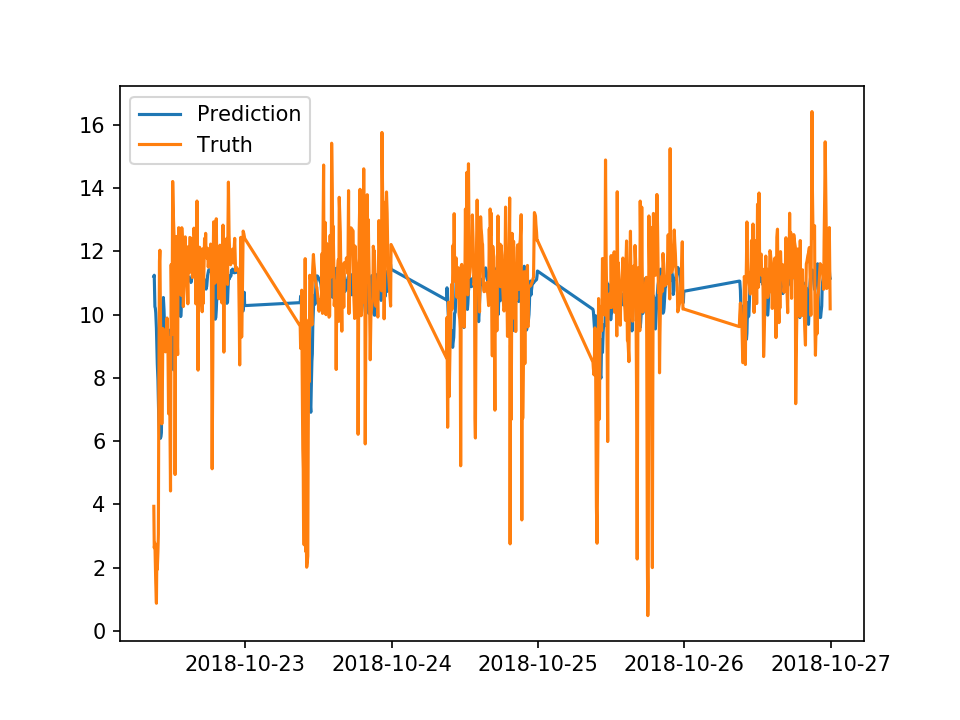

In [42]:
%matplotlib notebook

net.visualize_road(timesteps=6, road=23)